In [1]:
from __future__ import print_function
import os
import sys
import math
import pickle
import pdb
import argparse
import random
from tqdm import tqdm
from shutil import copy
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from scipy.linalg import qr 
import igraph as ig
from random import shuffle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from util import *
from modelsRIGHT import *
from igraph import *
import networkx as nx
from collections import Counter
import importlib
from sklearn.decomposition import PCA
from dotmap import DotMap
import pandas as pd
import json
from scipy.stats import wasserstein_distance
import csv
from pathlib import Path
import re
import visualize_util
from visualize_util import *




In [2]:
p = os.path.join("vertex_5_7dim_latent_KL0.1_DVAE_NOBATCHNORM_ROW_hs128_batchsize64","final_structures6_2")
vis_path = os.path.join(p, "evaluation")
csv_file_path = "summary.csv"
if( not os.path.exists(vis_path)):
    os.makedirs(vis_path)
argsFile = os.path.join(p,"cmd_input.txt")
with open(argsFile) as f:
    argsJSON = json.load(f)
args = DotMap(argsJSON)


In [4]:
# df = pd.read_csv("vertex_4_2dim_latent_batchnorm2\\final_structures6\\train_loss.txt", sep= " ")
# df2 = pd.read_csv("vertex_4_4dim_latent\\final_structures6\\train_loss.txt", sep= " ")
# df3 = pd.read_csv("train_lossBIG.txt", sep= " ")
# df4 = pd.read_csv("vertex_4_2dimLatent_new\\final_structures6\\train_loss.txt", sep= " ")
df5 = pd.read_csv(os.path.join(p,"train_loss.txt"), sep= " ")

ix=df5.iloc[:,[0,2]].sum(1).idxmin()
print(ix)
# print(df5.iloc[[300]])


54


<Figure size 640x480 with 0 Axes>

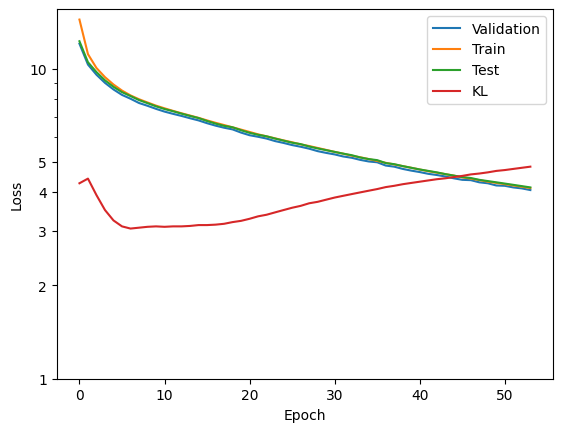

In [3]:
plt.figure(dpi = 100)
fig1, ax1 = plt.subplots()
ax1.plot(df5.iloc[:,3], label='Validation')
ax1.plot(df5.iloc[:,0], label='Train')
ax1.plot(df5.iloc[:,4], label='Test')
ax1.plot(df5.iloc[:,2], label='KL')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_yscale('log')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')


ax1.legend()
ax1.set_yticks([10,5,4,3,2,1])
ax1.set_yticklabels([10,5,4,3,2,1])
ax1.get_yaxis().get_major_formatter().labelOnlyBase = False
# plt.plot(df3.iloc[:2949,4], label='Total')

In [4]:

print(args.seed)
print(args)
print(type(args.seed))
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
np.random.seed(args.seed)
random.seed(args.seed)
print(device)


1
DotMap(data_type='BN', data_name='final_structures6', nvt=7, max_n=7, save_appendix='', save_interval=1, sample_number=20, no_test=False, reprocess=False, keep_old=False, only_test=False, small_train=False, model='DVAE_NOBATCHNORM_ROW', hs=128, nz=7, beta=0.1, save_start=0, early_stop_patience=50, lr=0.0001, epochs=3000, batch_size=64, load_latest_model=False, continue_from=None, bidirectional=False, infer_batch_size=32, no_cuda=False, all_gpus=False, seed=1, cuda=True, file_dir='/home/banfizsombor/D-VAE', res_dir='/home/banfizsombor/D-VAE/vertex_5_7dim_latent_KL0.1_DVAE_NOBATCHNORM_ROW_hs128_batchsize64/final_structures6_2', scheduler_dir='/home/banfizsombor/D-VAE/vertex_5_7dim_latent_KL0.1_DVAE_NOBATCHNORM_ROW_hs128_batchsize64/final_structures6_2/scheduler', optimizer_dir='/home/banfizsombor/D-VAE/vertex_5_7dim_latent_KL0.1_DVAE_NOBATCHNORM_ROW_hs128_batchsize64/final_structures6_2/optimizer', model_dir='/home/banfizsombor/D-VAE/vertex_5_7dim_latent_KL0.1_DVAE_NOBATCHNORM_ROW_hs12

In [5]:
graph_args = DotMap()
graph_args.max_n = args.nvt
graph_args.num_vertex_type = args.max_n
graph_args.START_TYPE = 0
graph_args.END_TYPE = 1
model = eval(args.model)(
        graph_args.max_n, 
        graph_args.num_vertex_type, 
        graph_args.START_TYPE, 
        graph_args.END_TYPE, 
        hs=args.hs, 
        nz=args.nz, 
        bidirectional=args.bidirectional        )
model.device = device
model = model.to(device)
print(model.get_device())
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)
print(graph_args)

cuda:0
DotMap(max_n=7, num_vertex_type=7, START_TYPE=0, END_TYPE=1)


In [6]:
all_data = []
all_data_cleaned = []
train_data = []
test_data = []
graph_path = os.path.join("..", "graph_data", "vertex_5")
for ix,filename in enumerate(tqdm(os.listdir(graph_path))):
    path = os.path.join(graph_path, filename)
    with open(path, 'rb') as pickle_file:
        # Load file
        graph = pickle.load(pickle_file)
        edge_list = graph.get_edgelist()
        # Create new graph
        graph2 = ig.Graph(directed=True)
        graph2.add_vertices(args.max_n)
        # Copy vertices to new graph
        for vs_i in range(len(graph.vs)):
            graph2.vs[vs_i+1]['type'] =  graph.vs[vs_i]['_nx_name']+2
        # Copy edges to new graph
        for edge_pair in edge_list:
            p1 = edge_pair[0]
            p2 = edge_pair[1]
            graph2.add_edge(p1+1,p2+1)
        # Set vertex attributes
        graph2.vs[0]['type'] = graph_args.START_TYPE
        graph2.vs[args.max_n-1]['type'] = graph_args.END_TYPE
        # graph2.add_edge(0,1)
        # graph2.add_edge(4,5)

        for vs_i,vs in enumerate(graph2.vs[1:-1]):
            if(len(vs.in_edges()) == 0):
                graph2.add_edge(0, vs_i+1)
            if(len(vs.out_edges()) == 0):
                graph2.add_edge(vs_i+1, len(graph2.vs)-1)
        all_data.append(graph2)
        all_data_cleaned.append(graph2)

print(all_data[0].vs["type"])
# print(all_data[1].vs["type"])
print(len(all_data))
number_of_graphs = len(all_data_cleaned)



100%|██████████| 29281/29281 [00:06<00:00, 4734.87it/s]

[0, 4, 6, 5, 2, 3, 1]
29281


In [7]:
print(visualize_util.DAG_hash(all_data_cleaned[0]))


nodeTypes
12345600230450460006040


In [8]:
def DAG_hash2(graph):
        g = graph
        nodeTypes = sorted(g.vs["type"])
        n2 =  "".join([str(nodeType) for nodeType in nodeTypes + [0]] + [str(neighbour)  for nodeType in nodeTypes for neighbour in sorted([g.vs[nodeIndex]["type"] for nodeIndex in g.neighbors(g.vs.find(type = nodeType), 'in')])+[0]])
        # n2 =  "".join([str(neighbour)  for nodeType in nodeTypes for neighbour in sorted([g.vs[nodeIndex]["type"] for nodeIndex in g.neighbors(g.vs.find(type = nodeType), 'in')])+[0]])
        return int(n2)
DAG_hash2(all_data_cleaned[0])

12345600230450460006040

In [9]:

model_dir = os.path.join(p, "model")
print(model_dir)
files = [os.path.join(model_dir, file) for file in os.listdir(model_dir)]
file_dict = {int(re.findall(r'\d+', Path(file).name)[0]):file for file in files}
f_l = [int(re.findall(r'\d+', Path(file).name)[0]) for file in files]
max_epoch = max(file_dict.keys())

last_epoch = file_dict[max_epoch]
print(last_epoch)
load_module_state(model,last_epoch)

# max_epoch = 70
# latest_checkpoint = os.path.join(model_dir,"model_checkpoint"+str(max_epoch)+".pth")
# print(latest_checkpoint)
# load_module_state(model,latest_checkpoint)





vertex_5_7dim_latent_KL0.1_DVAE_NOBATCHNORM_ROW_hs128_batchsize64/final_structures6_2/model
vertex_5_7dim_latent_KL0.1_DVAE_NOBATCHNORM_ROW_hs128_batchsize64/final_structures6_2/model/model_checkpoint55.pth


In [10]:
# ENCODE ALL DATA

importlib.reload(visualize_util)

latents = []
extended = []
min_mu = 2
max_mu = -1
min_g = None
max_g = None
percect_recon = 0
i = 0
for data in tqdm(all_data):
    mu, logvar = model.encode(data)
    z = model.reparameterize(mu,logvar)
    # g_recon = model.decode(z)

    # h1 = visualize_util.DAG_hash(data)
    # for g_r in g_recon:
    #     h2 = visualize_util.DAG_hash(g_r)
    #     if h1 == h2:
    #         percect_recon+=1
    #         break
    mu = mu.cpu().detach().numpy()

    latents.append(mu)
    null_edges = data.neighbors(0, 'out')
    # print(data.vcount())
    end_edges = data.neighbors(args.max_n-1, 'in')
    max_degree = np.max(data.vs.degree())
    in_degree = np.max(data.vs.indegree())
    out_degree = np.max(data.vs.outdegree())
    zero_pred =  len([ix for ix in range(data.vcount()) if  data.neighbors(ix, "in") == [0]])    
    zero_succ = len([ix for ix in range(data.vcount()) if  data.neighbors(ix, "out") == [args.max_n-1]])
    
    minus_edges = len(null_edges) + len(end_edges)
    mu  = np.append(mu, data.ecount()- minus_edges)
    mu  = np.append(mu, max_degree)
    mu  = np.append(mu, in_degree)
    mu  = np.append(mu, out_degree)
    mu  = np.append(mu, zero_pred)
    mu  = np.append(mu, zero_succ)





    
    extended.append(mu)

latents = np.array(latents)
extended = np.array(extended)
print(latents.shape)
# print(latents)

100%|█████████▉| 29149/29281 [02:51<00:00, 169.71it/s]


KeyboardInterrupt: 

In [ ]:
print("Z_mean: " + str(latents.mean(0)))
print("Z_std: " + str(latents.std(0)))
print("Z norm: " + str(np.linalg.norm(latents)))

Z_mean: [[-0.08546303  0.2794515   0.6171366  -0.4131878  -0.08246192  0.80562913
  -0.58262753]]
Z_std: [[1.1597075  1.0840056  0.7915347  1.2059106  1.1315473  1.044849
  0.93981814]]
Z norm: 527.09576


<class 'numpy.ndarray'>


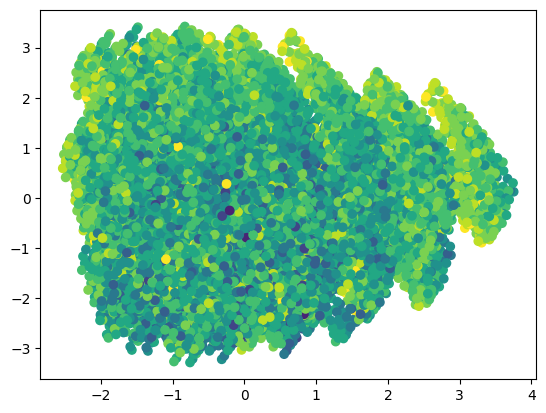

In [ ]:
a = latents.reshape((number_of_graphs,args.nz))
pca = PCA(n_components=2)
components = pca.fit_transform(a)
print(type(components))

fig, ax = plt.subplots(facecolor=(1, 1, 1))
scatter = ax.scatter(components[:,0], components[:,1], c=extended[:,args.nz])

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left",bbox_to_anchor=(1.04, 1))
ax.add_artist(legend1)
fig_name = os.path.join(vis_path, "all_data_encoded")
fig.savefig(fig_name,bbox_inches='tight')
plt.show()



In [ ]:


def prior_validity():
    Z_train = latents
    Zs_valid = []
    Zs_invalid = []
    Zs_plus_decode = []
    Wrapped_G = []
    z_mean, z_std = np.array(Z_train.mean(0)) ,np.array(Z_train.std(0)) 
    # print(z_mean)
    # print(z_std)
    z_mean, z_std = torch.FloatTensor(z_mean).to(device), torch.FloatTensor(z_std).to(device)
    n_latent_points = 1000
    decode_times = 10
    n_valid = 0
    print('Prior validity experiment begins...')
    G = []
    G_valid = []
    G_train = [g for g in train_data]
    pbar = tqdm(range(n_latent_points))
    cnt = 0
    G_valid = []
    G_invalid = []
    n_valid = 0
    for i in pbar:
        cnt += 1
        if cnt == args.infer_batch_size or i == n_latent_points - 1:
            z = torch.randn(cnt, model.nz).to(model.get_device())
        # print(z)
            z = z * z_std + z_mean  # move to train's latent range
        # print(z)
            
            # print(z.cpu().detach().numpy())

            for j in range(decode_times):
                g_batch = model.decode(z)
                for ix,g in enumerate(g_batch):
                    if is_valid_BN(g, graph_args.START_TYPE, graph_args.END_TYPE,args.nvt):
                        n_valid +=1
                        G_valid.append(g)
                        Wrapped_G.append(GraphWrapper(g))
                        Zs_valid.append(z.cpu().detach().numpy()[ix])
                    else:
                        G_invalid.append(g)
                        Zs_invalid.append(z.cpu().detach().numpy()[ix])


            cnt = 0
    return G_valid, G_invalid, Zs_valid, Zs_invalid, Wrapped_G


valid, invalid, Zs_valid, Zs_invalid, Wrapped_G = prior_validity()
print(len(valid))
print(len(invalid))


Prior validity experiment begins...


100%|██████████| 1000/1000 [00:41<00:00, 23.95it/s]

7075
2925


In [ ]:
print(number_of_graphs)
print(len(valid))
valid_cleaned = valid.copy()


for g in valid_cleaned:
    to_delete_ids = [v.index for v in g.vs if v["type"] == 0 or v["type"] == 1]
    g.delete_vertices(to_delete_ids)

29281
7075


In [ ]:
for g in all_data_cleaned:
    to_delete_ids = [v.index for v in g.vs if v["type"] == 0 or v["type"] == 1]
    g.delete_vertices(to_delete_ids)

In [ ]:
input()

In [ ]:
# TODO
# Hash all_data, create {hash, index} map, map hashes, create array from indexes, np hist
import importlib
import sys
importlib.reload(visualize_util)
all_data_hashes  = {}
# all_data_hashes = {visualize_util.DAG_hash(a):ix for (ix,a) in enumerate(all_data_cleaned) }
# ch = 23456045046006040
for ix,a_d in enumerate(all_data_cleaned):
    h = DAG_hash2(a_d)
    all_data_hashes[h] = ix
    print(h)
# print(all_data_hashes)


In [ ]:
del all_data_cleaned
%whos
input()

Variable                       Type                          Data/Info
----------------------------------------------------------------------
ADJ_DIRECTED                   int                           0
ADJ_LOWER                      int                           3
ADJ_MAX                        int                           6
ADJ_MIN                        int                           4
ADJ_PLUS                       int                           5
ADJ_UNDIRECTED                 int                           1
ADJ_UPPER                      int                           2
ALL                            int                           3
ARPACKOptions                  type                          <class 'igraph.ARPACKOptions'>
AdvancedGradientPalette        ABCMeta                       <class 'igraph.drawing.co<...>AdvancedGradientPalette'>
BFSIter                        type                          <class 'igraph.BFSIter'>
BLISS_F                        int                         

In [ ]:
hash_indexes =[]
hashes = []
# hashes = [ visualize_util.DAG_hash(w_g) for w_g in valid]
# print(all_data_hashes)
for w_g in valid_cleaned:
    h = DAG_hash2(w_g)
    if h in all_data_hashes:
        ix = all_data_hashes[h]
    else:
        print("meh")
    # print(h)
    hash_indexes.append(ix)
    hashes.append(h)

# print(len(hashes))
# counter = collections.Counter(hashes)
# c_values = list(counter.values())
# print(c_values)
# hashes.append(visualize_util.DAG_hash(valid[0]))

: 

: 

In [ ]:
print(type(valid))
print(all_data_cleaned[0])

<class 'list'>
IGRAPH D--T 5 10 --
+ attr: H_forward (v), type (v)
+ edges:
0->1 0->2 0->3 0->4 1->2 1->3 1->4 2->3 2->4 3->4


In [ ]:
counter = collections.Counter(hashes)
c_values = list(counter.values())

# print(c_values)

In [ ]:
print(np.max(c_values))
print(hashes[0])

93
234560045605606020


43514


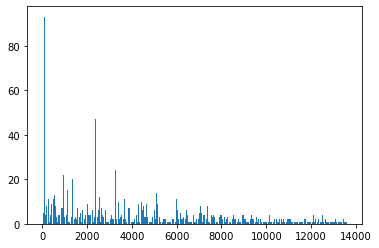

[38, 2, 4, 1, 13, 23, 5, 3, 6, 1, 2, 26, 1, 2, 4, 3, 4, 1, 5, 18, 30, 2, 6, 6, 25, 5, 9, 3, 5, 1, 5, 5, 2, 2, 14, 3, 5, 1, 31, 3, 6, 10, 3, 3, 1, 37, 6, 4, 19, 7, 4, 3, 2, 69, 14, 3, 2, 3, 18, 5, 15, 3, 4, 3, 23, 1, 2, 23, 6, 12, 14, 19, 2, 12, 1, 6, 2, 4, 6, 1, 2, 3, 4, 25, 2, 13, 1, 5, 8, 1, 3, 8, 2, 4, 10, 32, 27, 8, 56, 6, 2, 5, 1, 9, 93, 14, 12, 5, 47, 6, 1, 2, 2, 1, 3, 15, 2, 8, 2, 56, 5, 3, 8, 10, 2, 1, 21, 14, 3, 15, 2, 6, 4, 3, 7, 2, 1, 2, 9, 4, 7, 7, 6, 3, 3, 8, 16, 2, 4, 11, 14, 11, 8, 3, 9, 23, 4, 8, 12, 4, 17, 5, 2, 5, 2, 1, 8, 6, 5, 10, 5, 4, 10, 2, 8, 3, 4, 2, 6, 1, 4, 6, 1, 4, 4, 6, 4, 8, 1, 2, 5, 11, 1, 8, 7, 19, 6, 2, 3, 1, 11, 1, 1, 3, 1, 7, 21, 3, 1, 3, 2, 2, 10, 1, 6, 1, 32, 6, 4, 25, 11, 1, 59, 1, 3, 2, 10, 4, 5, 1, 2, 3, 1, 2, 3, 5, 22, 2, 7, 1, 14, 2, 2, 17, 2, 3, 2, 9, 6, 3, 1, 2, 11, 10, 3, 6, 6, 2, 19, 1, 2, 28, 4, 8, 1, 1, 4, 8, 4, 6, 14, 1, 2, 2, 4, 1, 4, 1, 10, 1, 11, 3, 11, 15, 8, 1, 3, 2, 2, 1, 7, 9, 16, 4, 8, 8, 9, 12, 4, 48, 1, 17, 6, 3, 2, 11, 3, 2, 2

In [ ]:
mapped_hashes = [ all_data_hashes[h] if h in all_data_hashes else number_of_graphs for h in hashes]
print(len(mapped_hashes))

counter = collections.Counter(mapped_hashes)
c_values = list(counter.values())
plt.bar([i for i in range(len(c_values))], c_values)
plt.show()
print(c_values)
print(len(c_values))

In [ ]:
print(mapped_hashes[:10])
print(np.max(mapped_hashes))
print(number_of_graphs)
print(list(all_data_hashes.values())[-1])

[24920, 13329, 21447, 20276, 6247, 24504, 18735, 21409, 4705, 17223]
29279
29281
29280


In [ ]:
# print(all_data_hashes)

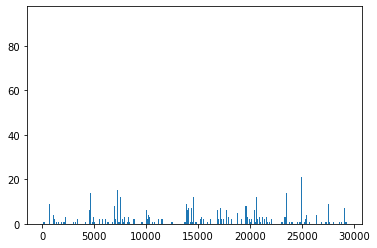

In [ ]:
hist1 = np.histogram(mapped_hashes,bins = number_of_graphs)
plt.bar([i for i in range(len(hist1[0]))], hist1[0])
fig_name = os.path.join(vis_path, "frequencies")
plt.savefig(fig_name,bbox_inches='tight', facecolor=(1, 1, 1))
plt.show()


In [ ]:
print(hist1[0])
print(len(hist1[0]))
print(np.argmax(hist1[0]))
all_set = set(all_data_hashes.keys())
valid_set = set(hashes)

missing = all_set - valid_set
print(len(valid_set))
print(missing)
print(len(missing))

[14  4  8 ...  5  0  2]
29281
25019
13579
{23456030560256000, 2345603456045056000, 234560350560256000, 23456045026050050, 234560450560000, 2345605602050050, 234560560202350600, 2345606024003600, 2345600450560020, 2345603002040340, 2345605050040340, 234560402560024600, 2345604602460602400, 234560402002346020, 234560300260360230, 23456046020034600, 2345603460036034600, 234560026050600, 2345605060034600, 234560025002030, 234560402002346030, 234560060260400, 2345605604606000, 2345603600023600, 2345603505602560050, 23456002450260020, 2345604505600050, 234560305602560050, 234560350060600, 234560025002040, 2345600202604600, 234560305004600, 234560402002346040, 23456034560450560050, 23456045003604030, 234560024500240450, 234560460030030, 2345600602603600, 2345603060203600, 234560500203600, 234560360602304600, 23456045050560600, 23456004602560600, 234560460030050, 234560560260350050, 23456050502500450, 23456000235602020, 2345603606020200, 234560450003050, 23456000235602030, 23456034003026030, 2

In [ ]:
print(hist1)


(array([14,  4,  8, ...,  5,  0,  2], dtype=int64), array([0.00000000e+00, 9.99931696e-01, 1.99986339e+00, ...,
       2.92770001e+04, 2.92780001e+04, 2.92790000e+04]))


In [ ]:
uni = np.random.randint(0,542,number_of_graphs)
uni2 = np.random.randint(0,542,number_of_graphs)
m_mean =np.mean(hist1[0][:-2])
m_median =np.median(hist1[0][:-2])
m_std = np.std(hist1[0][:-2])
m_max = np.max(hist1[0][:-2])
m_max_ix = np.argmax(hist1[0])
m_wasser = wasserstein_distance(uni,hist1[0][:-2])
non_zeros = np.count_nonzero(hist1[0][:-2])
versatility = non_zeros/number_of_graphs
print("Mean: " + str(m_mean))
print("Median: " + str(m_median))
print("Std: " + str(m_std))
print("Max: " + str(m_max))
print("Max index: " + str(m_max_ix))
print("Distance from uniform distribution: " + str(m_wasser))
print("Uni to Uni: " + str(wasserstein_distance(uni,uni2)))
print("Versatility:" + str(versatility))
dir_name = Path(p).parent.name

# csv_file_path = "s2.csv"
with open(csv_file_path, 'a+', newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter = ';' )
    writer.writerow([dir_name,args.model, max_epoch, args.nz, args.hs,  args.beta,m_mean, m_median, m_std,m_max, m_wasser, len(valid),versatility])



Mean: 1.4861163291096007
Median: 0.0
Std: 3.3114156734466094
Max: 93
Max index: 25019
Distance from uniform distribution: 269.1539232870237
Uni to Uni: 1.5856698883234839
Versatility:0.4637136709811823


In [ ]:
print(hist1[0][:-2])

print(non_zeros)

[14  4  8 ...  1  1  5]
13578


29281


<BarContainer object of 543 artists>

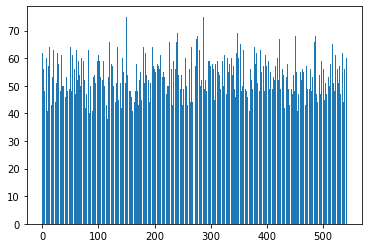

In [ ]:
# print(uni)
print(len(uni))
hist2 = np.histogram(uni, bins=543)
plt.bar([i for i in range(len(hist2[0]))], hist2[0])

In [ ]:
test_g = all_data_cleaned[0]
print(test_g)
print(test_g.get_adjacency())
flat_list = [item for sublist in test_g.get_adjacency()[1:] for item in sublist[:-1]]
print(flat_list)
print(len(flat_list))
print(test_g.vs["type"])
hash_list = flat_list + test_g.vs["type"]
print(hash_list)
hash_list_str = ''.join(map(str,hash_list))
print(int(hash_list_str))

IGRAPH D--T 5 10 --
+ attr: H_forward (v), type (v)
+ edges:
0->1 0->2 0->3 0->4 1->2 1->3 1->4 2->3 2->4 3->4
[[0, 1, 1, 1, 1]
 [0, 0, 1, 1, 1]
 [0, 0, 0, 1, 1]
 [0, 0, 0, 0, 1]
 [0, 0, 0, 0, 0]]
[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
16
[2, 3, 4, 5, 6]
[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 4, 5, 6]
1100010000000023456


In [ ]:
Zs_valid = np.array(Zs_valid)
print(Zs_valid.shape)

pca = PCA(n_components=2)
sampled_components = pca.fit_transform(Zs_valid)
# plt.scatter(components[:,0], components[:,1], c=extended[:,6])

plt.scatter(sampled_components[:,0], sampled_components[:,1], c=decode_ix)
fig_name = os.path.join(vis_path, "sampled")
plt.savefig(fig_name,bbox_inches='tight', facecolor=(1, 1, 1))

# plt.scatter(Zs_valid[:,0], Zs_valid[:,1], c=decode_ix)

(43514, 7)


NameError: name 'decode_ix' is not defined

In [ ]:
most_common = counter.most_common(1)[0][0]
print(most_common)

to_print = [ix for ix in range(len(decode_ix)) if decode_ix[ix] == most_common]
print(len(to_print))
Zs_valid_filtered = [Zs_valid[x] for x in range(len(Zs_valid)) if x in to_print]
print(len(Zs_valid_filtered))
Zs_valid_filtered = np.array(Zs_valid_filtered)
plt.scatter(Zs_valid_filtered[:,0], Zs_valid_filtered[:,1])

In [ ]:
Zs_invalid = np.array(Zs_invalid)
print(Zs_invalid.shape)
plt.scatter(Zs_invalid[:,0], Zs_invalid[:,1])